A canonical way of importing the `bulbea` module is as follows:

In [1]:
import bulbea as bb

In [2]:
from coinmarketcap_draw import coinmarketcap_data

Go ahead and create a `Share` object as follows:

In [3]:
coin_name = 'raiden-network-token'
data = coinmarketcap_data(coin_name)

In [4]:
nsamples = 10
data.tail(nsamples)

,market_cap,price_btc,price_usd,volume_usd,volume_token,Close
2017-12-06 00:49:00,161182190.0,0.000272,3.21407,14022300.0,4.362786e+06,3.21407
2017-12-06 01:04:00,162160094.0,0.000273,3.23357,14048400.0,4.344548e+06,3.23357
2017-12-06 01:19:00,160411401.0,0.000269,3.19870,13928900.0,4.354550e+06,3.19870
2017-12-06 01:34:00,159586953.0,0.000268,3.18226,13794200.0,4.334718e+06,3.18226
2017-12-06 01:49:00,159269510.0,0.000267,3.17593,13756100.0,4.331361e+06,3.17593
2017-12-06 02:04:00,159412434.0,0.000266,3.17878,13848700.0,4.356609e+06,3.17878
2017-12-06 02:19:00,159768492.0,0.000266,3.18588,13891600.0,4.360365e+06,3.18588
2017-12-06 02:34:00,156420047.0,0.000257,3.11911,13737200.0,4.404205e+06,3.11911
2017-12-06 02:49:00,155511850.0,0.000256,3.10100,13675200.0,4.409932e+06,3.10100
2017-12-06 02:54:00,154615187.0,0.000255,3.08312,13662000.0,4.431226e+06,3.08312


In order to analyse a given attribute, you could plot the same as follows:

##  Convert the data to hourly

In [5]:
from datetime import timedelta
import pandas as pd

def convert_with_n_hour_gap(data,n):
    times = data.index.copy()
    first_time = times[0].to_datetime()
    v_dict = dict()
    
    for x in range(1,len(times)):
        t = times[x].to_datetime()
        if n == 24:
            success = t.day == first_time.day + 1
        else:
            success = (first_time + timedelta(hours=n)).hour == t.hour
        if success:
            first_time = t
            index = pd.Timestamp(t)
            v_dict[index] = data.loc[index]['Close']
    df = pd.DataFrame(list(v_dict.items()), columns=['Date', 'Close'])
    df.set_index("Date",inplace=True)
    return df

In [45]:
share_array = []
for i in range(1,25):
    df = convert_with_n_hour_gap(data,i)
    share = bb.Share("123",'123',data=df)
    share_array.append(share)

/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/entity/share.py:174: UserWarning: Environment variable BULBEA_QUANDL_API_KEY for Quandl hasn't been set. A maximum of 50000 calls per day can be made. Visit https://www.quandl.com to get your API key.
  warnings.warn(message)


## visualize the 24 hour data

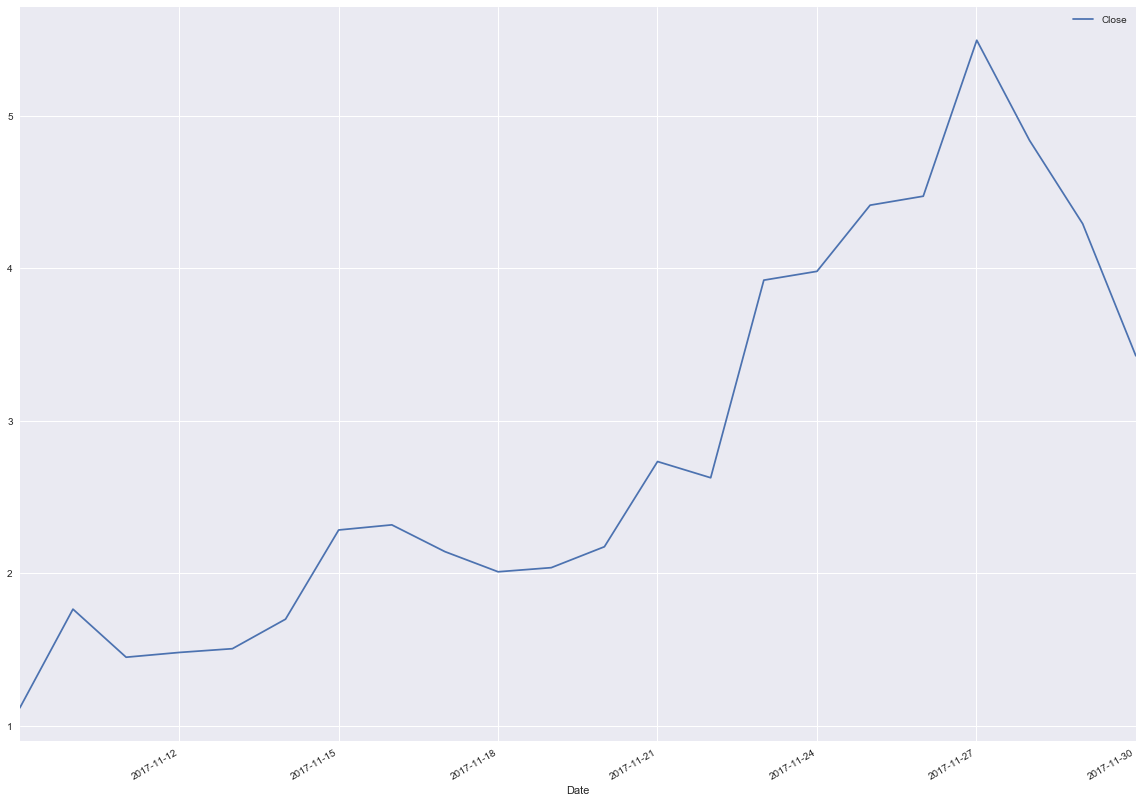

In [46]:
% matplotlib inline
share_array[-1].plot(['Close'], figsize = (20, 15), bollinger_bands = True, period = 100, bandwidth = 2)

## visualize the 1 hour data

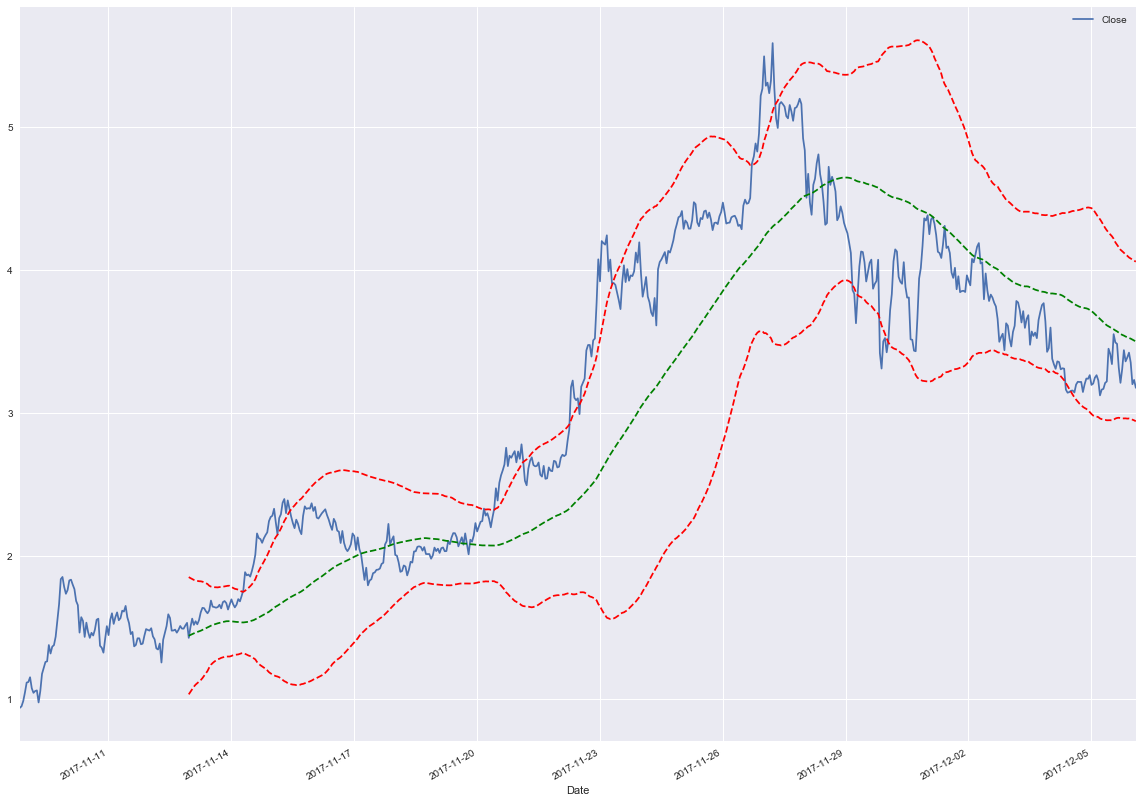

In [47]:
% matplotlib inline
share_array[0].plot(['Close'], figsize = (20, 15), bollinger_bands = True, period = 100, bandwidth = 2)

### Modelling

In [48]:
from bulbea.learn.models import RNN

### Training & Testing

In [49]:
from bulbea.learn.evaluation import split
import numpy as np

In [50]:
rnn_arr = []
for index,share in enumerate(share_array):
    print("{} hour. {}".format(index+1,len(share.data)))
    print(share.data.tail(5))
    Xtrain, _, ytrain, _ = split(share, 'Close', normalize = True)
    Xtrain  = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))
    
    # Training
    rnn = RNN([1, 100, 100, 1]) # number of neurons in each layer
    rnn.fit(Xtrain, ytrain)
    rnn_arr.append(rnn)
    

1 hour. 655
                       Close
Date                        
2017-12-05 22:04:00  3.42441
2017-12-05 23:04:00  3.35535
2017-12-06 00:04:00  3.20364
2017-12-06 01:04:00  3.23357
2017-12-06 02:04:00  3.17878
7 648


/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/learn/models/ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/learn/models/ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/learn/models/ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))


Epoch 1/10
389/389 [==============================] - 4s - loss: 0.0054      
Epoch 2/10
389/389 [==============================] - 0s - loss: 0.0035     

#### TESTING

1 hour. 655
                       Close
Date                        
2017-12-05 22:04:00  3.42441
2017-12-05 23:04:00  3.35535
2017-12-06 00:04:00  3.20364
2017-12-06 01:04:00  3.23357
2017-12-06 02:04:00  3.17878
7 648
0.001250259783
7 648


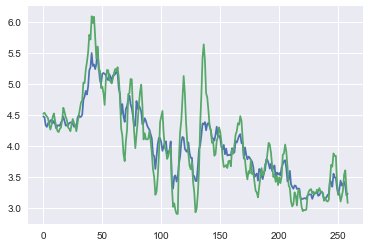

2 hour. 327
                       Close
Date                        
2017-12-05 17:04:00  3.21329
2017-12-05 19:04:00  3.44179
2017-12-05 21:04:00  3.39057
2017-12-05 23:04:00  3.35535
2017-12-06 01:04:00  3.23357
3 324
0.0019750533346
3 324


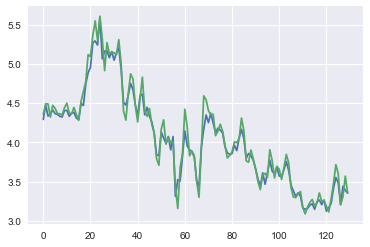

3 hour. 218
                       Close
Date                        
2017-12-05 13:04:00  3.55377
2017-12-05 16:04:00  3.31950
2017-12-05 19:04:00  3.44179
2017-12-05 22:04:00  3.42441
2017-12-06 01:04:00  3.23357
2 216
0.00342042499835
2 216


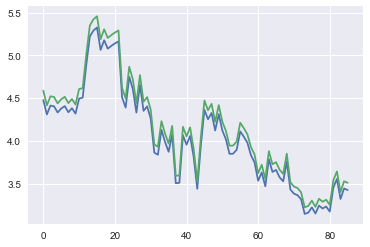

4 hour. 163
                       Close
Date                        
2017-12-05 07:04:00  3.17106
2017-12-05 11:04:00  3.41525
2017-12-05 15:04:00  3.48594
2017-12-05 19:04:00  3.44179
2017-12-05 23:04:00  3.35535
2 161
0.00299262510862
2 161


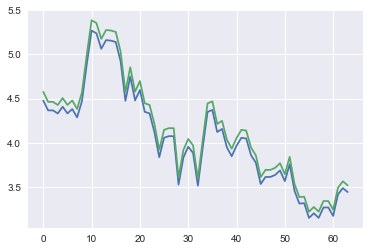

5 hour. 131
                       Close
Date                        
2017-12-05 06:04:00  3.16589
2017-12-05 11:04:00  3.41525
2017-12-05 16:04:00  3.31950
2017-12-05 21:04:00  3.39057
2017-12-06 02:04:00  3.17878
2 129
0.00503753905286
2 129


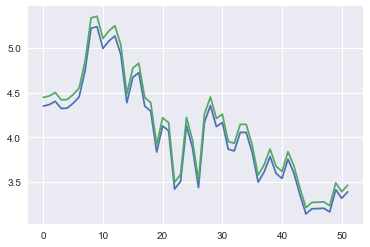

6 hour. 109
                       Close
Date                        
2017-12-05 01:04:00  3.20787
2017-12-05 07:04:00  3.17106
2017-12-05 13:04:00  3.55377
2017-12-05 19:04:00  3.44179
2017-12-06 01:04:00  3.23357
2 107
0.00435855146126
2 107


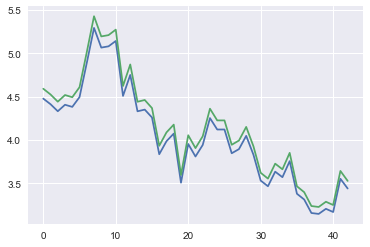

7 hour. 93
                       Close
Date                        
2017-12-04 18:04:00  3.21956
2017-12-05 01:04:00  3.20787
2017-12-05 08:04:00  3.21225
2017-12-05 15:04:00  3.48594
2017-12-05 22:04:00  3.42441
2 91
0.0062796515371
2 91


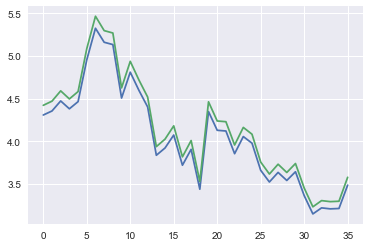

8 hour. 81
                       Close
Date                        
2017-12-04 11:04:00  3.14864
2017-12-04 19:04:00  3.14918
2017-12-05 03:04:00  3.26664
2017-12-05 11:04:00  3.41525
2017-12-05 19:04:00  3.44179
2 79
0.00483006309031
2 79


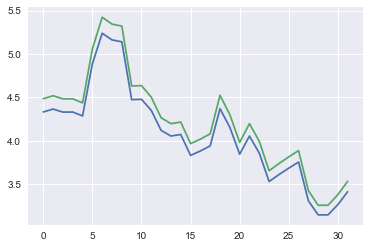

9 hour. 72
                       Close
Date                        
2017-12-04 07:04:00  3.31522
2017-12-04 16:04:00  3.22066
2017-12-05 01:04:00  3.20787
2017-12-05 10:04:00  3.45203
2017-12-05 19:04:00  3.44179
2 70
0.00503949064479
2 70


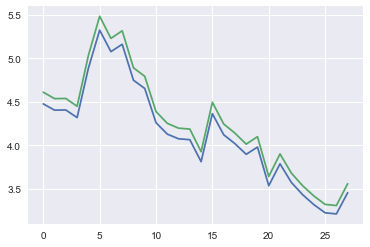

10 hour. 65
                       Close
Date                        
2017-12-04 05:04:00  3.35879
2017-12-04 15:04:00  3.20143
2017-12-05 01:04:00  3.20787
2017-12-05 11:04:00  3.41525
2017-12-05 21:04:00  3.39057
2 63
0.00659054136913
2 63


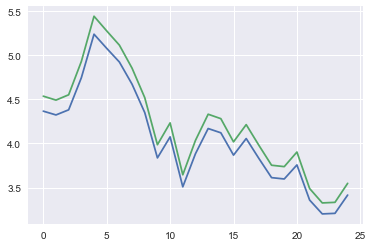

11 hour. 59
                       Close
Date                        
2017-12-04 00:04:00  3.59993
2017-12-04 11:04:00  3.14864
2017-12-04 22:04:00  3.24155
2017-12-05 09:04:00  3.22322
2017-12-05 20:04:00  3.36325
2 57
0.0108243434304
2 57


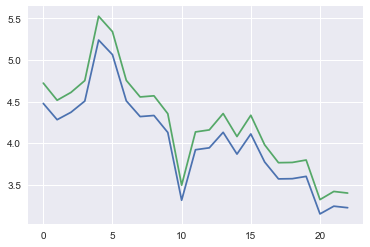

12 hour. 54
                       Close
Date                        
2017-12-03 19:04:00  3.75679
2017-12-04 07:04:00  3.31522
2017-12-04 19:04:00  3.14918
2017-12-05 07:04:00  3.17106
2017-12-05 19:04:00  3.44179
2 52
0.00923050258859
2 52


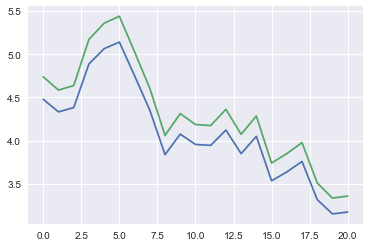

13 hour. 50
                       Close
Date                        
2017-12-03 17:04:00  3.65259
2017-12-04 06:04:00  3.30780
2017-12-04 19:04:00  3.14918
2017-12-05 08:04:00  3.21225
2017-12-05 21:04:00  3.39057
2 48
0.012871446624
2 48


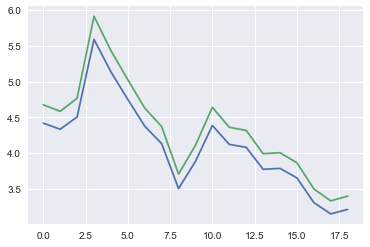

14 hour. 46
                       Close
Date                        
2017-12-03 07:04:00  3.63552
2017-12-03 21:04:00  3.64327
2017-12-04 11:04:00  3.14864
2017-12-05 01:04:00  3.20787
2017-12-05 15:04:00  3.48594
2 44
0.0108866122521
2 44


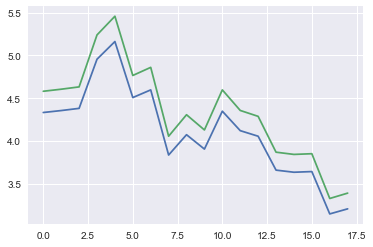

15 hour. 43
                       Close
Date                        
2017-12-03 04:04:00  3.78558
2017-12-03 19:04:00  3.75679
2017-12-04 10:04:00  3.14431
2017-12-05 01:04:00  3.20787
2017-12-05 16:04:00  3.31950
2 41
0.01487209265
2 41


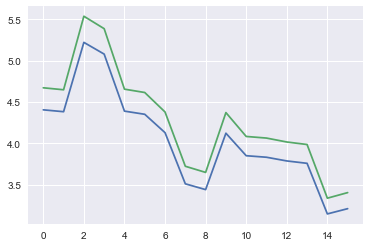

16 hour. 40
                       Close
Date                        
2017-12-02 19:04:00  3.53282
2017-12-03 11:04:00  3.68646
2017-12-04 03:04:00  3.31144
2017-12-04 19:04:00  3.14918
2017-12-05 11:04:00  3.41525
2 38
0.0112047291407
2 38


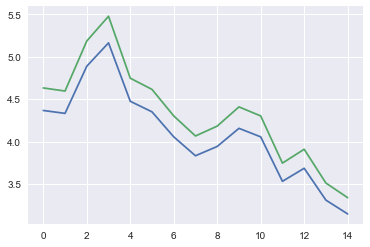

17 hour. 38
                       Close
Date                        
2017-12-02 21:04:00  3.44116
2017-12-03 14:04:00  3.54108
2017-12-04 07:04:00  3.31522
2017-12-05 00:04:00  3.19882
2017-12-05 17:04:00  3.21329
2 36
0.0183344256014
2 36


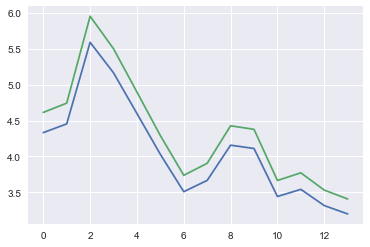

18 hour. 36
                       Close
Date                        
2017-12-02 19:04:00  3.53282
2017-12-03 13:04:00  3.57218
2017-12-04 07:04:00  3.31522
2017-12-05 01:04:00  3.20787
2017-12-05 19:04:00  3.44179
2 34
0.0104407727407
2 34


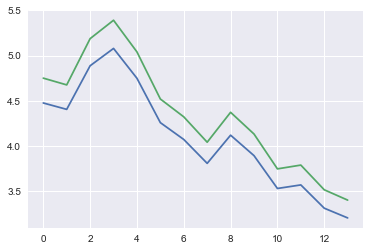

19 hour. 34
                       Close
Date                        
2017-12-02 13:04:00  3.83038
2017-12-03 08:04:00  3.71471
2017-12-04 03:04:00  3.31144
2017-12-04 22:04:00  3.24155
2017-12-05 17:04:00  3.21329
2 32
0.0156918229319
2 32


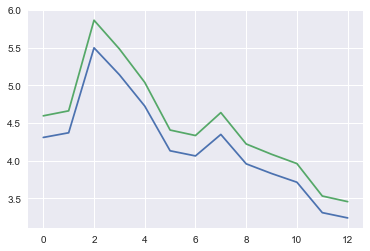

20 hour. 32
                       Close
Date                        
2017-12-02 03:04:00  4.05610
2017-12-02 23:04:00  3.61281
2017-12-03 19:04:00  3.75679
2017-12-04 15:04:00  3.20143
2017-12-05 11:04:00  3.41525
2 30
0.0157401542013
2 30


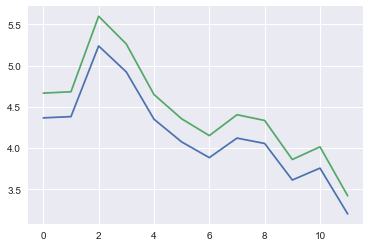

21 hour. 31
                       Close
Date                        
2017-12-02 10:04:00  3.97830
2017-12-03 07:04:00  3.63552
2017-12-04 04:04:00  3.36358
2017-12-05 01:04:00  3.20787
2017-12-05 22:04:00  3.42441
2 29
0.0204783516025
2 29


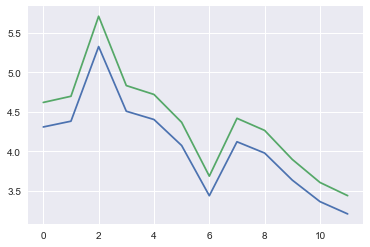

22 hour. 29
                       Close
Date                        
2017-12-01 17:04:00  3.86784
2017-12-02 15:04:00  3.77302
2017-12-03 13:04:00  3.57218
2017-12-04 11:04:00  3.14864
2017-12-05 09:04:00  3.22322
2 27
0.0250407616819
2 27


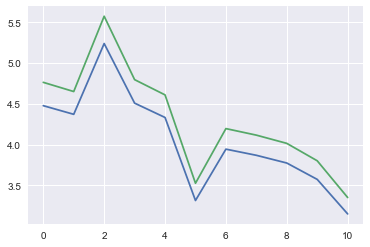

23 hour. 28
                       Close
Date                        
2017-12-01 19:04:00  3.84757
2017-12-02 18:04:00  3.50026
2017-12-03 17:04:00  3.65259
2017-12-04 16:04:00  3.22066
2017-12-05 15:04:00  3.48594
2 26
0.0294298075922
2 26


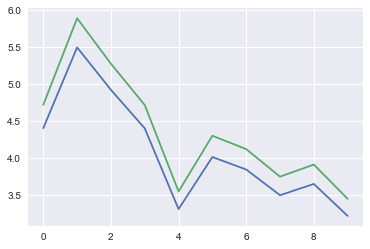

24 hour. 22
                       Close
Date                        
2017-11-26 00:04:00  4.47376
2017-11-27 00:14:00  5.49705
2017-11-28 00:04:00  4.83985
2017-11-29 00:04:00  4.29294
2017-11-30 00:04:00  3.42678
2 20
0.036754479141
2 20


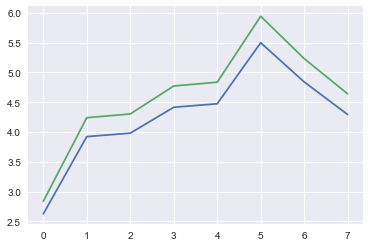

In [51]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pplt
from bulbea.entity.share import _reverse_cummulative_return
from datetime import datetime

for index,share in enumerate(share_array):
    print("{} hour. {}".format(index+1,len(share.data)))
    print(share.data.tail(5))
    _, Xtest, _, ytest = split(share, 'Close', normalize = True)
    Xtest  = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))
    rnn = rnn_arr[index]
    predicted = rnn.predict(Xtest)
    sqr_err = mean_squared_error(ytest, predicted)
    print(sqr_err)
    
    
    _,_,_,ori_ytest = split(share, 'Close', normalize = False)
    
    new_pre = []
    for x in range(0,len(ori_ytest)):
        t = ori_ytest[x]
        predict = predicted[x]
        new_pre.append(_reverse_cummulative_return(t,predict))

    pplt.plot(ori_ytest)
    pplt.plot(new_pre)
    pplt.show()

    rnn.model.save("models/{}_{}.h5".format(coin_name,index+1))